In [1]:
import numpy as np
import pandas as pd

import os
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
from collections import OrderedDict
import random as rnd
rnd.seed(100)

import matplotlib.pyplot as plt
import seaborn as sns

import gresearch_crypto

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.random.set_seed(200)
print('tf version:', tf.__version__)

# Check GPU Availability in Tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

# List Devices including GPU's with Tensorflow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# Check GPU in Tensorflow
tf.test.is_gpu_available()
    

FOLDER = os.path.join(os.getcwd(), 'dev')
if not os.path.isdir(FOLDER):
    os.mkdir(FOLDER)
    print('created', FOLDER)

tf version: 2.6.0
created /kaggle/working/dev



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [2]:
def weighted_correlation(a, b, weights):
    
    w = np.ravel(weights)
    a = np.ravel(a)
    b = np.ravel(b)
    
    sum_w = np.sum(w)
    mean_a = np.sum(a * w) / sum_w
    mean_b = np.sum(b * w) / sum_w
    var_a = np.sum(w * np.square(a - mean_a)) / sum_w
    var_b = np.sum(w * np.square(b - mean_b)) / sum_w
    
    cov = np.sum((a * b * w)) / np.sum(w) - mean_a * mean_b
    corr = cov / np.sqrt(var_a * var_b)
    
    return corr

In [3]:
dtype = {'Asset_ID': 'int8', 'Weight': float, 'Asset_Name': str}
asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv', dtype=dtype)
asset_details = asset_details.sort_values(by=['Asset_ID']).reset_index(drop=True)
weights = asset_details['Weight'].values.astype('float32')
asset_details

,Asset_ID,Weight,Asset_Name
0,0,4.304065,Binance Coin
1,1,6.779922,Bitcoin
2,2,2.397895,Bitcoin Cash
3,3,4.406719,Cardano
4,4,3.555348,Dogecoin
5,5,1.386294,EOS.IO
6,6,5.894403,Ethereum
7,7,2.079442,Ethereum Classic
8,8,1.098612,IOTA
9,9,2.397895,Litecoin


In [4]:
dtype = {'timestamp': 'int64', 'Asset_ID': 'int8', 'Count': 'int32', 
         'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64',
         'Volume': 'float64', 'VWAP': 'float64', 'Target': 'float64'}

df = pd.DataFrame()
for fname in ['train.csv', 'supplemental_train.csv']:
    df = df.append(pd.read_csv(f'../input/g-research-crypto-forecasting/{fname}', low_memory=False, dtype=dtype))

dt = df['timestamp'].astype('datetime64[s]')
print([dt.min(), dt.max()])
del dt

print(df.shape)
df.head()

[Timestamp('2018-01-01 00:01:00'), Timestamp('2022-01-10 00:00:00')]
(26473300, 10)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [5]:
def prep_asset(df_):
    df = df_.drop('Asset_ID', axis=1).copy()
    df['datetime'] = df['timestamp'].astype('datetime64[s]')
    df = df.set_index('datetime')    
    df = df.sort_index()
    df = df.loc[~df.index.duplicated()]
    df[df.isin([np.inf, -np.inf])] = np.nan
    df = df.reindex( pd.date_range(start=df.index.min(), end=df.index.max(), freq='min') )
    df = df.interpolate(method='linear', limit_direction='both', axis=0)
    return df

dfs = OrderedDict([(i, prep_asset(df[df['Asset_ID']==i])) for i in range(14)])
del df
dfs_prod = {i: df.loc[[df.index[-1]]].copy() for i, df in dfs.items()}

dfs[0].head()

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target
2018-01-01 00:01:00,1.514765e+09,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399
2018-01-01 00:02:00,1.514765e+09,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875
2018-01-01 00:03:00,1.514765e+09,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410
2018-01-01 00:04:00,1.514765e+09,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524
2018-01-01 00:05:00,1.514765e+09,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940


In [6]:
def time_bounds(dfs, left_shift=0, right_shift=0):
    start = max([df.index.min() for df in dfs.values()]) + relativedelta(months=left_shift)
    end = min([df.index.max() for df in dfs.values()]) - relativedelta(months=right_shift)
    return start, end

def trim_dfs(dfs):
    start, end = time_bounds(dfs)
    print(start, end)
    for i, df in dfs.items():
        dfs[i] = df[start:]

trim_dfs(dfs)

2019-04-12 14:34:00 2022-01-10 00:00:00


In [7]:
def enrich(df, suffix=''):
    df['Upper_Shadow'+suffix] = df['High'].values / np.maximum(df['Close'].values, df['Open'].values)
    df['Lower_Shadow'+suffix] =  np.minimum(df['Close'].values, df['Open'].values) / df['Low'].values
    df['spread'+suffix] = df['High'].values / df['Low'].values
    #df['mean_trade'+suffix] = df['Volume'].values/df['Count'].values
    df['price_change'+suffix] = df['Close'].values/df['Open'].values    

def enrichment(dfs):   
    for i in range(14):
        enrich(dfs[i])
        
enrichment(dfs)

dfs[1].head(3)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,spread,price_change
2019-04-12 14:34:00,1.555080e+09,335.0,5060.981429,5102.7,5028.80,5062.270039,77.507280,5061.913876,-0.001882,1.007987,1.006399,1.014695,1.000255
2019-04-12 14:35:00,1.555080e+09,393.0,5062.335714,5103.1,5029.93,5064.698571,69.980211,5063.865985,-0.000731,1.007582,1.006443,1.014547,1.000467
2019-04-12 14:36:00,1.555080e+09,385.0,5064.660000,5107.1,5032.67,5064.230000,43.839321,5064.879145,-0.001341,1.008380,1.006271,1.014789,0.999915


In [8]:
def treat_trend(dfs):
    for i in range(14):
        df = dfs[i]
        for col in ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']: #, 'mean_trade'
            s = df[col]
            s_trans = s/np.maximum(s.shift(1), 1e-5)
            df[col] = s_trans
        dfs[i] = df.dropna()

treat_trend(dfs)
dfs[1].head(3)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,spread,price_change
2019-04-12 14:35:00,1.555080e+09,1.173134,1.000268,1.000078,1.000225,1.000480,0.902886,1.000386,-0.000731,1.007582,1.006443,1.014547,1.000467
2019-04-12 14:36:00,1.555080e+09,0.979644,1.000459,1.000784,1.000545,0.999907,0.626453,1.000200,-0.001341,1.008380,1.006271,1.014789,0.999915
2019-04-12 14:37:00,1.555080e+09,0.657143,0.999677,0.999922,0.999928,0.999974,0.398982,0.999697,-0.001508,1.008412,1.006104,1.014782,1.000212


In [9]:
def treat_outliers(dfs):
    bounds = {}
    columns = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'] #, 'mean_trade'
    columns_q25 = [col+'_q25' for col in columns]
    columns_q75 = [col+'_q75' for col in columns]
    columns_join = ['month','hour']
    
    for i in range(14):
        df = dfs[i]
        
        df_q25 = df[columns].groupby([df.index.month, df.index.hour]).agg(lambda x: np.percentile(x, 25))   
        df_q25 = df_q25.add_suffix('_q25')
        df_q25[columns_join[0]] = df_q25.index.get_level_values(0)
        df_q25[columns_join[1]] = df_q25.index.get_level_values(1)
        
        df_q75 = df[columns].groupby([df.index.month, df.index.hour]).agg(lambda x: np.percentile(x, 75))   
        df_q75 = df_q75.add_suffix('_q75')
        df_q75[columns_join[0]] = df_q75.index.get_level_values(0)
        df_q75[columns_join[1]] = df_q75.index.get_level_values(1)
        
        df[columns_join[0]] = df.index.month
        df[columns_join[1]] = df.index.hour
        
        df = df.merge(df_q25, on=columns_join, how='left').merge(df_q75, on=columns_join, how='left')
        
        q25 = df[columns_q25].values
        q75 = df[columns_q75].values
        iqr = q75 - q25
        cut_off = iqr * 3
        lb = q25 - cut_off
        ub = q75 + cut_off
        
        df.loc[:,columns] = np.maximum(lb, np.minimum(df.loc[:,columns].values, ub))
            
        df = df.drop(columns_q25+columns_q75+columns_join, axis=1)
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df = df.set_index('datetime')  
        dfs[i] = df
    
        bounds['lb_{}'.format(i)] = lb
        bounds['ub_{}'.format(i)] = ub
        
    return bounds

bounds = treat_outliers(dfs)

In [10]:
def smoothing(dfs):
    for i in range(14):
        dfs[i]['Target'] = dfs[i]['Target'].ewm(span=5).mean()

smoothing(dfs)

In [11]:
def target_scaler(dfs):    
    from sklearn.preprocessing import MinMaxScaler
    tscalers = {}
    for i in range(14):  
        tscalers[i] = MinMaxScaler(feature_range=(-1, 1))
        values = dfs[i]['Target'].values.reshape(-1,1)        
        dfs[i]['Target'] = tscalers[i].fit_transform(values)
    return tscalers

tscalers = target_scaler(dfs)

'\nfor col in dfs[1].iloc[:,1:]:\n    plt.figure()\n    dfs[1][col].plot()\n    plt.title(col)'

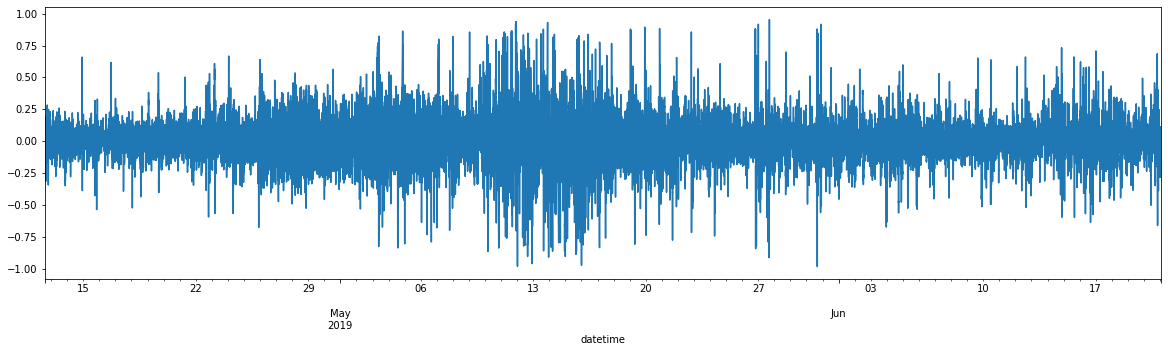

In [12]:
plt.figure(figsize=(20,5))
dfs[1][:100000].Target.plot()
#plt.ylabel('value')
#plt.xlabel('data')

"""
for col in dfs[1].iloc[:,1:]:
    plt.figure()
    dfs[1][col].plot()
    plt.title(col)"""

In [13]:
def add_lagged(dfs):
    for i, df in dfs.items():
        df_lag = df.drop(['timestamp', 'Target'], axis=1).shift(periods=1).add_suffix('_lag1')
        dfs[i] =  pd.concat([df, df_lag], axis=1).dropna()

add_lagged(dfs)
dfs[1].head(3)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,...,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,VWAP_lag1,Upper_Shadow_lag1,Lower_Shadow_lag1,spread_lag1,price_change_lag1
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-12 14:36:00,1.555080e+09,0.979644,1.000459,1.000784,1.000545,0.999907,0.626453,1.000200,-0.124579,1.008380,...,1.000268,1.000078,1.000225,1.000480,0.902886,1.000386,1.007582,1.006443,1.014547,1.000467
2019-04-12 14:37:00,1.555080e+09,0.657143,0.999677,0.999922,0.999928,0.999974,0.398982,0.999697,-0.147740,1.008412,...,1.000459,1.000784,1.000545,0.999907,0.626453,1.000200,1.008380,1.006271,1.014789,0.999915
2019-04-12 14:38:00,1.555080e+09,0.940711,1.000172,1.000078,0.999789,1.000076,2.040121,1.000136,-0.165796,1.008414,...,0.999677,0.999922,0.999928,0.999974,0.398982,0.999697,1.008412,1.006104,1.014782,1.000212


In [14]:
#dfs[1].groupby([dfs[1].index.year, dfs[1].index.month])['Target'].mean().plot()
#pd.Timestamp(1514764860, unit='s').weekday()

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer


def timestamp_func(df):
    
    max_month = 12
    max_weekday = 6
    max_hour = 23
    max_minute = 59    
    max_hour_minute = max_hour*max_minute + max_minute

    month = df.index.month
    weekday = df.index.weekday
    hour_minute = df.index.hour*max_minute + df.index.minute
    
    arr = np.zeros((len(df), 6), dtype='float32')
    # month
    arr[:,0] = np.sin(month * (2 * np.pi / max_month))
    arr[:,1] = np.cos(month * (2 * np.pi / max_month))
    # weekday
    arr[:,2] = np.sin(weekday * (2 * np.pi / max_weekday))
    arr[:,3] = np.cos(weekday * (2 * np.pi / max_weekday))
    # hour_minute
    arr[:,4] = np.sin(hour_minute * (2 * np.pi / max_hour_minute))
    arr[:,5] = np.cos(hour_minute * (2 * np.pi / max_hour_minute))
    
    return arr

columns = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']
columns += ['Upper_Shadow', 'Lower_Shadow', 'spread', 'price_change'] #'mean_trade', 
columns += [col+'_lag1' for col in columns]

pipelines = {'time': FunctionTransformer(func=lambda x: timestamp_func(x))}
for i, df in dfs.items():
    extractor = FunctionTransformer(func=lambda x: x[columns].values)
    scaler = StandardScaler()
    pipe = make_pipeline(extractor, scaler)
    pipelines[i] = pipe.fit(df)

n_cyclic = timestamp_func(dfs[0]).shape[1]
n_features = pipelines[0].transform(dfs[0]).shape[1]

In [16]:
def data_generator(dfs, start, end, pipelines, batch_size=256, shuffle=True, epochs=1):
    """A data generator function"""    
    
    # create an array with the indexes that can be shuffled
    indexes = dfs[0][start:end].index.tolist()
    length = len(indexes)
    
    # shuffle the indexes
    if shuffle:
        rnd.shuffle(indexes)
    
    # init 
    idx = 0 # current location
    batch_indexes = [0] * batch_size    
    epoch = 0
    flag = False
    
    targets = np.zeros((batch_size,14), dtype='float32')
    features = np.zeros((batch_size,14,n_features), dtype='float32')
    time_encoding = np.zeros((batch_size,14,n_cyclic), dtype='float32') 
    asset_encoding = np.tile(np.expand_dims(np.eye(14, dtype='float32'), axis=0), (batch_size,1,1))
    encodings = np.concatenate([time_encoding, asset_encoding], axis=-1)
    
    while True:
        
        if flag:
            break
        
        for i in range(batch_size):
            if idx >= length:
                epoch += 1
                flag = epoch>=epochs # determine if continue after pass through data
                idx = 0
                if shuffle:
                    rnd.shuffle(indexes)                    
            batch_indexes[i] = indexes[idx]            
            idx += 1        
        
        for i, df in dfs.items():
            df_batch = df.loc[batch_indexes]
            features[:,i,:] = pipelines[i].transform(df_batch)
            encodings[:,i,:n_cyclic] = pipelines['time'].transform(df_batch)            
            targets[:,i] = df_batch['Target']
        
        inputs = [features, encodings]
                
        yield inputs, targets

# testing
#start, end = time_bounds(dfs)
#generator = data_generator(dfs, start, end, pipelines)
#inputs, targets = next(generator)

In [17]:
def custom_loss(weights):
    
    w = tf.constant(weights / weights.sum())
    
    def weighted_correlation(a, b):
        
        mean_a = tf.reduce_sum(a * w, keepdims=True, axis=-1)
        mean_b = tf.reduce_sum(b * w, keepdims=True, axis=-1)   
        var_a = tf.reduce_sum(tf.math.square(a - mean_a) * w, keepdims=True, axis=-1)
        var_b = tf.reduce_sum(tf.math.square(b - mean_b) * w, keepdims=True, axis=-1)

        cov = tf.reduce_sum(a * b * w, keepdims=True, axis=-1) - mean_a * mean_b   
        corr = cov / (tf.sqrt(var_a * var_b) + 1e-6) 
        
        loss = 1. - tf.reduce_mean(corr)
        return loss
    
    def wrapper(y_true, y_pred):
        loss = tf.keras.losses.mean_absolute_percentage_error(y_true, y_pred)
        #loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
        return loss
    
    def mse(y_true, y_pred):
        errors = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        loss = tf.reduce_mean(errors * w)        
        return loss
    
    def cosine_similarity(y_true, y_pred):
        dot = tf.reduce_sum(y_true * y_pred, axis=0)
        norm_true = tf.norm(y_true, axis=0)
        norm_pred = tf.norm(y_pred, axis=0)
        similarity = 1. - dot / (norm_true*norm_pred + 1e-6)            
        loss = tf.reduce_sum(similarity * w)
        return loss
    
    return wrapper

# tf.tensor_scatter_nd_update
#mask = tf.greater_equal(a, 2)
#indexes = tf.where(mask) 

from tensorflow.keras.regularizers import l2 as reg_l2

def build_model(n_features, n_cyclic, weights):

    features = tf.keras.layers.Input(shape=(14, n_features))
    encodings = tf.keras.layers.Input(shape=(14, n_cyclic+14))
    
    embed = features
    #embed = tf.keras.layers.Dense(32*2, activation="relu")(features)
    #embed = tf.keras.layers.Dense(16*2)(embed)
    
    attentions = []
    for i in range(4):
        query = tf.keras.layers.Dense(16, kernel_regularizer=reg_l2(1e-3))(embed)
        value =  tf.keras.layers.Dense(16, kernel_regularizer=reg_l2(1e-3))(embed)
        key   =  tf.keras.layers.Dense(16, kernel_regularizer=reg_l2(1e-3))(embed)
        attention = tf.keras.layers.Attention()([query, value, key])
        attentions.append(attention)
    
    """
    query = tf.keras.layers.Dense(16, kernel_regularizer=reg_l2(1e-3))(embed)
    value =  tf.keras.layers.Dense(16, kernel_regularizer=reg_l2(1e-3))(embed)
    key   =  tf.keras.layers.Dense(16, kernel_regularizer=reg_l2(1e-3))(embed)
    attention = tf.keras.layers.Attention()([query, value, key])
    """
    attention = tf.concat(attentions, axis=-1)

    #attention = tf.keras.layers.Dropout(0.1)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention)

    hidden = tf.concat([attention, encodings], axis=-1)

    dense = tf.keras.layers.Dense(128*4, activation="relu", kernel_regularizer=reg_l2(1e-3))(hidden)
    #dense = tf.keras.layers.Dropout(0.1)(dense)
    outputs = tf.keras.layers.Dense(1, kernel_regularizer=reg_l2(1e-3))(dense)#, activation="tanh"
    outputs = tf.keras.layers.Flatten()(outputs)   

    model = tf.keras.models.Model(inputs=[features, encodings], outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_loss(weights))

    return model

# build
model = build_model(n_features, n_cyclic, weights)

model.summary()

2022-01-26 15:36:22.001595: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 22)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 14, 16)       368         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 14, 16)       368         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 14, 16)       368         input_1[0][0]                    
______________________________________________________________________________________________

In [18]:
#model.predict([np.random.randn(1, 14, n_features), np.random.randn(1, 14, n_cyclic+14)]).ravel()

In [19]:
def train_model(model):
    
    train_start, train_end = time_bounds(dfs, left_shift=12) #, right_shift=3
    _, val_end = time_bounds(dfs)

    #train_generator = data_generator(dfs, train_start, train_end, pipelines, epochs=10)
    #val_generator = data_generator(dfs, train_end, val_end, pipelines)    
    
    train_n = train_loss = 0
    val_n = val_loss = 0
    tic = time.time()    
    
    history = {'train_loss': [], 'val_loss': []}
    epochs = 4
    step = 0
        
    for epoch in range(1,epochs+1):     
        
        train_generator = data_generator(dfs, train_start, train_end, pipelines, batch_size=256, shuffle=True)
        
        while True:
            
            step += 1
            
            try:
                batch_inputs, batch_targets = next(train_generator)
            except:
                break

            train_loss += model.train_on_batch(batch_inputs, batch_targets)
            train_n += 1
            
            if False and step%5000==0:
                lr = model.optimizer.learning_rate.numpy()*0.75
                model.optimizer.learning_rate.assign(lr)            

            if step%500 == 0: 
                train_loss = np.sqrt(train_loss / train_n)
                print(f'step: {step} ------------------------')
                print('train_loss: {:.4f} train_time: {}'.format(train_loss, round((time.time()-tic)/60))) 
                history['train_loss'].append(train_loss)
                train_n = train_loss = 0
                tic = time.time()

            if False and step%1000 == 0:            
                val_generator = data_generator(dfs, train_end, val_end, pipelines, shuffle=False)
                while True:
                    try:
                        batch_inputs, batch_targets = next(val_generator)
                        batch_predictions = model(batch_inputs)
                        loss = custom_loss(batch_targets, batch_predictions, w)
                        val_n += 1
                        val_loss += loss.numpy()
                    except:
                        break
                val_loss = np.sqrt(val_loss / val_n)
                print('val_loss: {:.4f} val_time: {}'.format(val_loss, round((time.time()-tic)/60)))           
                history['val_loss'].append(val_loss)
                val_n = val_loss = 0
                tic = time.time()
            
    return history

history = train_model(model)

2022-01-26 15:36:32.686455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


step: 500 ------------------------
train_loss: 39.9625 train_time: 1
step: 1000 ------------------------
train_loss: 45.3939 train_time: 1
step: 1500 ------------------------
train_loss: 40.1853 train_time: 1
step: 2000 ------------------------
train_loss: 41.8953 train_time: 1
step: 2500 ------------------------
train_loss: 39.8589 train_time: 1
step: 3000 ------------------------
train_loss: 37.1840 train_time: 1
step: 3500 ------------------------
train_loss: 33.2178 train_time: 1
step: 4000 ------------------------
train_loss: 43.6062 train_time: 1
step: 4500 ------------------------
train_loss: 38.5890 train_time: 1
step: 5000 ------------------------
train_loss: 36.1897 train_time: 1
step: 5500 ------------------------
train_loss: 39.6136 train_time: 1
step: 6000 ------------------------
train_loss: 34.5450 train_time: 1
step: 6500 ------------------------
train_loss: 39.5164 train_time: 1
step: 7000 ------------------------
train_loss: 45.0481 train_time: 1
step: 7500 ----------

In [20]:
#model.save(f'{FOLDER}/model')
#model = tf.keras.models.load_model(f'{FOLDER}/model')

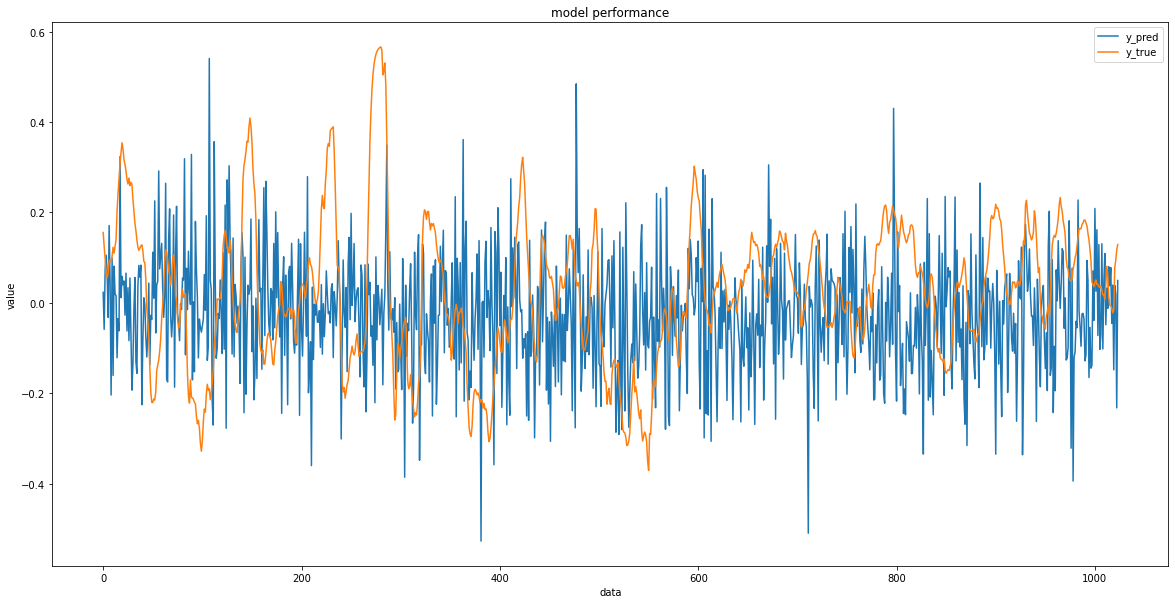

In [21]:
def show_performance():
    train_start, train_end = time_bounds(dfs, right_shift=3)
    _, val_end = time_bounds(dfs)

    #generator = data_generator(dfs, train_start, train_end, pipelines, shuffle=False) # train data
    generator = data_generator(dfs, train_end, val_end, pipelines, shuffle=False, batch_size=1024) # val

    batch_inputs, batch_targets = next(generator)
    batch_predictions = model.predict(batch_inputs)

    i = 1
    y_pred = batch_predictions[:,i]
    y_true = batch_targets[:,i]
    
    plt.figure(figsize=(20,10))
    #plt.plot(y_true-y_pred)
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.title('model performance')
    plt.ylabel('value')
    plt.xlabel('data')
    plt.legend(['y_pred', 'y_true'], loc='upper right')
    plt.show()

show_performance()

In [22]:
"""
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()"""

"\nplt.plot(history['train_loss'])\nplt.plot(history['val_loss'])\nplt.title('evolution of loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train_loss', 'val_loss'], loc='upper right')\nplt.show()"

In [23]:
columns_raw = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']
columns_enrich = ['Upper_Shadow', 'Lower_Shadow', 'spread', 'price_change']
columns_features = columns_raw + columns_enrich
columns_lag = [col+'_lag1' for col in columns_features]
columns_dev = columns_features+columns_lag

columns_features_prod = [col+'_prod' for col in columns_features]
columns_lag_prod = [col+'_prod' for col in columns_lag]
columns_prod = columns_features_prod + columns_lag_prod


def prepare_prod(dfs, dfs_prod, pipelines):
    pipelines_prod = {'time': pipelines['time']}
    for i in range(14):
        # prep dataframe
        idx = dfs[i].index[-1]
        dfs_prod[i][columns_prod] = dfs[i].loc[[idx],columns_dev].values
        # prep pipeline 
        extractor = FunctionTransformer(lambda x: x[columns_prod].values)
        scaler = pipelines[i].steps[1][1]
        pipelines_prod[i] = make_pipeline(extractor, scaler)
    return dfs_prod, pipelines_prod

dfs_prod, pipelines_prod = prepare_prod(dfs, dfs_prod, pipelines)


def make_input(pipes, df_test, dfs_prod, features, encodings):
    
    for _, row in df_test.iterrows():
        i = int(row['Asset_ID'])
        dfs_prod[i].loc[:,columns_lag_prod] = dfs_prod[i][columns_features_prod].values
        
        for col in columns_raw:
            if row[col]==row[col]:
                dfs_prod[i][col+'_prod'] = row[col] / np.maximum(1e-5, dfs_prod[i][col])
                dfs_prod[i][col] = row[col]
            else:
                dfs_prod[i][col+'_prod'] = 1.
        enrich(dfs_prod[i], suffix='_prod')
        # feature transformation
        features[0,i,:] = pipes[i].transform(dfs_prod[i])
    
    dfs_prod[i]['datetime'] = pd.to_datetime(df_test['timestamp'].values[0], unit='s')   
    dfs_prod[i] = dfs_prod[i].set_index('datetime')
    time_encodings = pipes['time'].transform(dfs_prod[i])
    encodings[0,:,:n_cyclic] = np.tile(time_encodings.reshape(1,n_cyclic), (14, 1))
    

def make_predictions(model, pipes, dfs_prod):    
    
    target_min = np.array([tscalers[i].data_min_[0] for i in range(14)])
    target_range = np.array([tscalers[i].data_range_[0] for i in range(14)])
    
    features = np.zeros((1, 14, n_features), dtype='float32')  
    encodings = np.zeros((1, 14, n_cyclic+14), dtype='float32')
    encodings[0,:,n_cyclic:] = np.eye(14, dtype='float32')
    
    for i in range(14):
        features[0,i,:] = pipes[i].transform(dfs_prod[i])
        

    env = gresearch_crypto.make_env()
    iter_test = env.iter_test()
    
    for df_test, df_pred in iter_test:
        
        try:                
            make_input(pipes, df_test, dfs_prod, features, encodings)

            predictions = model.predict([features, encodings]).ravel()
            predictions = np.nan_to_num(predictions * target_range + target_min) # rescale targets
            #print('success', predictions) 

            df_test['Target'] = predictions[df_test['Asset_ID']]            
            df_pred = df_pred.drop('Target', axis=1).merge(df_test[['row_id', 'Target']], on='row_id', how='left')
        except:            
            df_pred['Target'] = 0
            #print('failure')
        finally:
            env.predict(df_pred)

make_predictions(model, pipelines_prod, dfs_prod)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
